# Fourier Transform

## Setup


We'll use NumPy and OpenCV for image I/O, and Matplotlib for plotting. The section below contains the helper functions for all tasks in this file, to make the sections more concise and readable.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
from typing import Tuple
try:
    import cv2
    HAS_CV2 = True
except Exception:
    from PIL import Image
    HAS_CV2 = False


mpl.rcParams['figure.figsize'] = (6, 6)


def load_grayscale_image(path: str) -> np.ndarray:
    """Load an image as grayscale float32 in [0,1]."""
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"Image not found: {path}")
    if HAS_CV2:
        img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Unable to read image via OpenCV: {path}")
        img = img.astype(np.float32) / 255.0
        return img
    else:
        img = Image.open(str(p)).convert('L')
        arr = np.asarray(img, dtype=np.float32) / 255.0
        return arr


def show_image(img: np.ndarray, title: str = "", cmap: str = "gray") -> None:
    plt.imshow(np.clip(img, 0, 1), cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()


def fft2_img(img: np.ndarray) -> np.ndarray:
    return np.fft.fft2(img)


def fftshift_spectrum(F: np.ndarray) -> np.ndarray:
    return np.fft.fftshift(F)


def ifft2_img(F: np.ndarray) -> np.ndarray:
    img_rec = np.fft.ifft2(F)
    return np.real(img_rec)


def magnitude_spectrum(F_shift: np.ndarray, log: bool = True, eps: float = 1e-8) -> np.ndarray:
    mag = np.abs(F_shift)
    if log:
        mag = np.log(mag + eps)
    mag = (mag - mag.min()) / (mag.max() - mag.min() + 1e-12)
    return mag


def make_low_pass_mask(shape: Tuple[int,int], radius: int) -> np.ndarray:
    H, W = shape
    Y, X = np.ogrid[:H, :W]
    cy, cx = H // 2, W // 2
    dist2 = (Y - cy)**2 + (X - cx)**2
    mask = (dist2 <= radius**2).astype(np.float32)
    return mask


def make_high_pass_mask(shape: Tuple[int,int], radius: int) -> np.ndarray:
    return 1.0 - make_low_pass_mask(shape, radius)


def apply_filter_in_frequency(F_shift: np.ndarray, mask: np.ndarray) -> np.ndarray:
    return F_shift * mask

## 1) DFT of a grayscale image


Load a grayscale image, compute its 2D DFT, and visualize the magnitude spectrum.

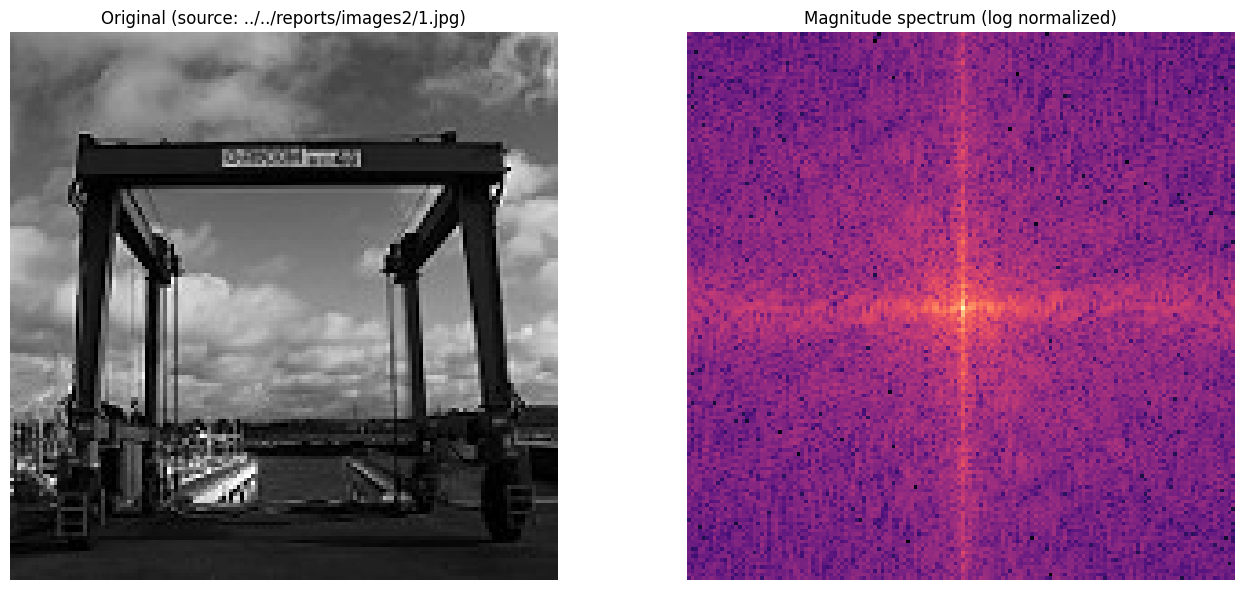

In [7]:

IMAGE_PATH = "../../reports/images2/1.jpg"
try:
    img = load_grayscale_image(IMAGE_PATH)
except FileNotFoundError:
    Y, X = np.mgrid[0:256, 0:256]
    img = (np.sin(2*np.pi*X/16) + np.sin(2*np.pi*Y/32)) * 0.25 + 0.5
    img = img.astype(np.float32)
    IMAGE_PATH = "<synthetic>"

F = fft2_img(img)
F_shift = fftshift_spectrum(F)
mag = magnitude_spectrum(F_shift, log=True)

# Display original and magnitude spectrum side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(np.clip(img, 0, 1), cmap='gray')
axes[0].set_title(f"Original (source: {IMAGE_PATH})")
axes[0].axis('off')

axes[1].imshow(mag, cmap='magma')
axes[1].set_title('Magnitude spectrum (log normalized)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### Explanation and how to read the spectrum

Applying the 2‑D discrete Fourier transform (DFT) rewrites the image as a weighted sum of spatial sinusoids. The magnitude abs(F(u,v)) tells us how much of each spatial frequency is present, while the phase encodes where structures appear. For visualization, the zero‑frequency (DC) term is shifted to the center (fftshift), and we plot log(abs(F)+ε) to compress the dynamic range so both strong and subtle components are visible.

Bright energy close to the center indicates that most power is in low frequencies, i.e., smooth content. A horizontal bright band across the center means strong vertical repetition in the image; a vertical band indicates repeated horizontal structure; diagonal streaks correspond to oriented textures.

## 2) Low-pass filtering


We keep low frequencies and attenuate high frequencies (noise/edges). Use a circular mask with radius R around the DC center.

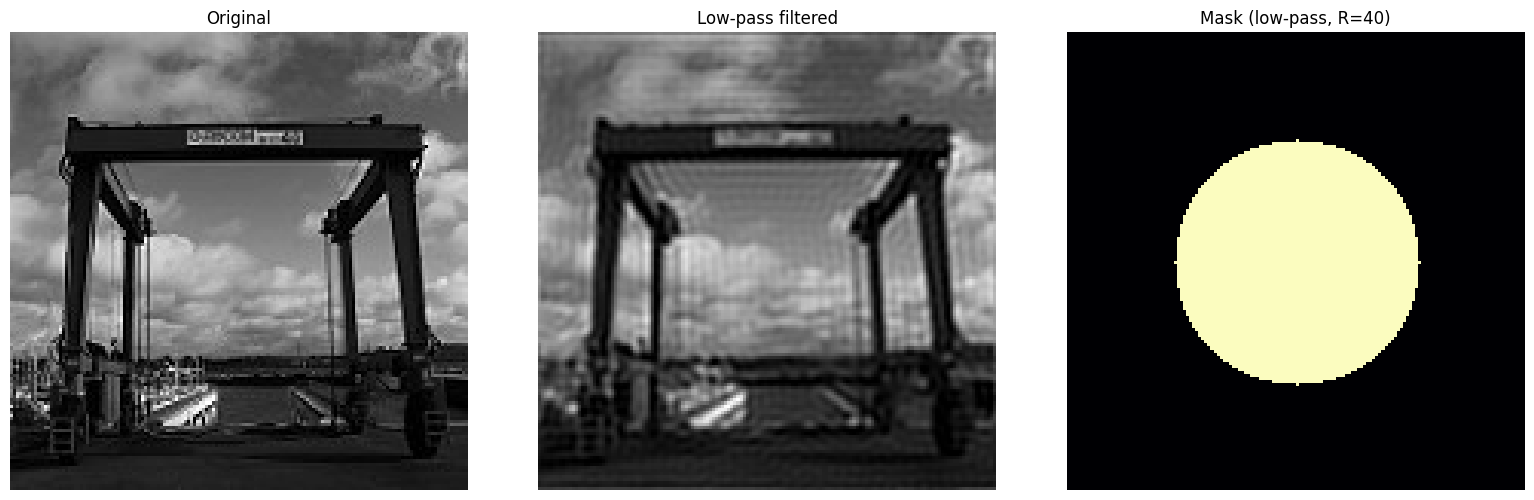

In [8]:
R = 40

# Build mask and apply
lp_mask = make_low_pass_mask(img.shape, radius=R)
F_lp = apply_filter_in_frequency(F_shift, lp_mask)
img_lp = ifft2_img(np.fft.ifftshift(F_lp))
img_lp = np.clip(img_lp, 0.0, 1.0)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(np.clip(img, 0, 1), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(np.clip(img_lp, 0, 1), cmap='gray')
axes[1].set_title('Low-pass filtered')
axes[1].axis('off')

axes[2].imshow(lp_mask, cmap='magma')
axes[2].set_title(f'Mask (low-pass, R={R})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

A circular low‑pass mask keeps all frequencies within a radius R of the spectrum center and suppresses higher frequencies. In the spatial domain, this removes rapid intensity changes: the reconstruction becomes smoother, small details and sensor noise are removed, and edges look softer. Increasing R raises the cut‑off and preserves more detail (weaker denoising), decreasing R lowers the cut‑off and yields stronger blur (stronger denoising).

Because the mask has a sharp boundary, slight Gibbs‑style ringing can appear near strong edges. A Gaussian low‑pass offers a gentler transition with fewer artifacts at the cost of a less precise cut‑off.

## 3) High-pass filtering


We remove low frequencies (smooth background) to highlight edges and fine details.

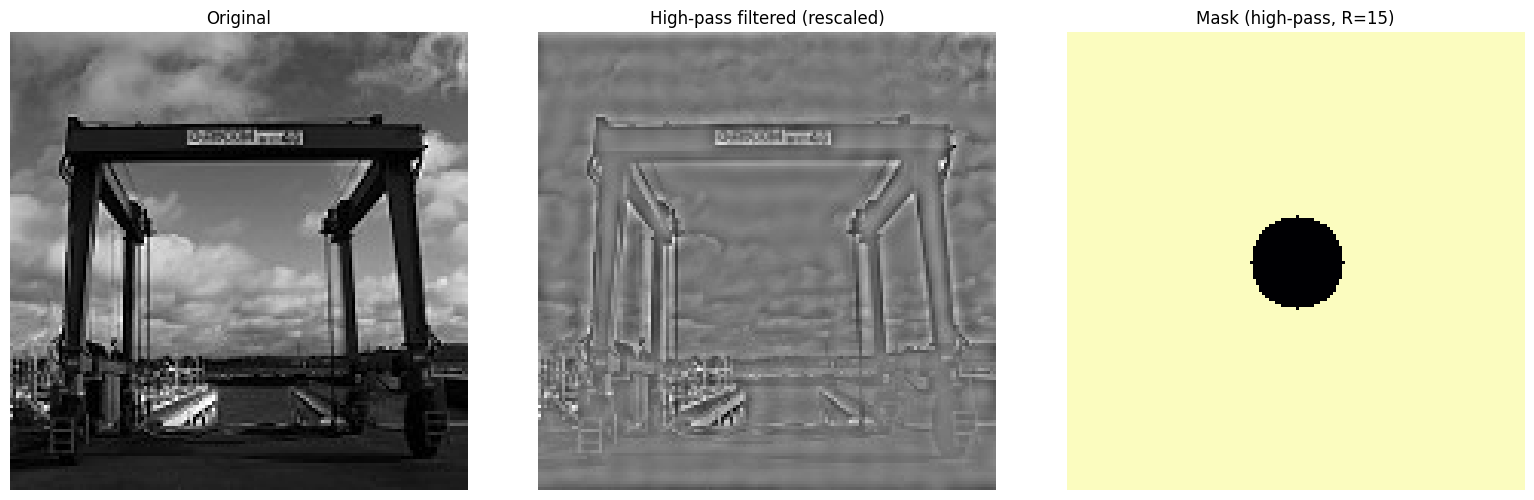

In [14]:
R = 15

hp_mask = make_high_pass_mask(img.shape, radius=R)
F_hp = apply_filter_in_frequency(F_shift, hp_mask)
img_hp = ifft2_img(np.fft.ifftshift(F_hp))

img_hp_disp = img_hp - img_hp.min()
img_hp_disp = img_hp_disp / (img_hp_disp.max() - img_hp_disp.min() + 1e-12)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(np.clip(img, 0, 1), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(np.clip(img_hp_disp, 0, 1), cmap='gray')
axes[1].set_title('High-pass filtered (rescaled)')
axes[1].axis('off')

axes[2].imshow(hp_mask, cmap='magma')
axes[2].set_title(f'Mask (high-pass, R={R})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

The high‑pass filter uses the complement of the low‑pass mask, suppressing low frequencies near the center and keeping energy outside the radius R. The inverse transform emphasizes derivatives: edges and fine texture are amplified while slowly varying backgrounds are reduced. Because high‑pass outputs are roughly zero‑mean, we rescale them for display. This affects appearance but not the qualitative effect.

Larger R removes more low‑frequency content and produces stronger edge enhancement, but it also amplifies noise and can introduce haloing around high‑contrast contours. Smaller R gives gentler sharpening and keeps more of the details in the picture. 

## 4) Compression with Fourier coefficients


We keep only a fraction p of the largest-magnitude Fourier coefficients and reconstruct the image. We then examine quality vs. compression.

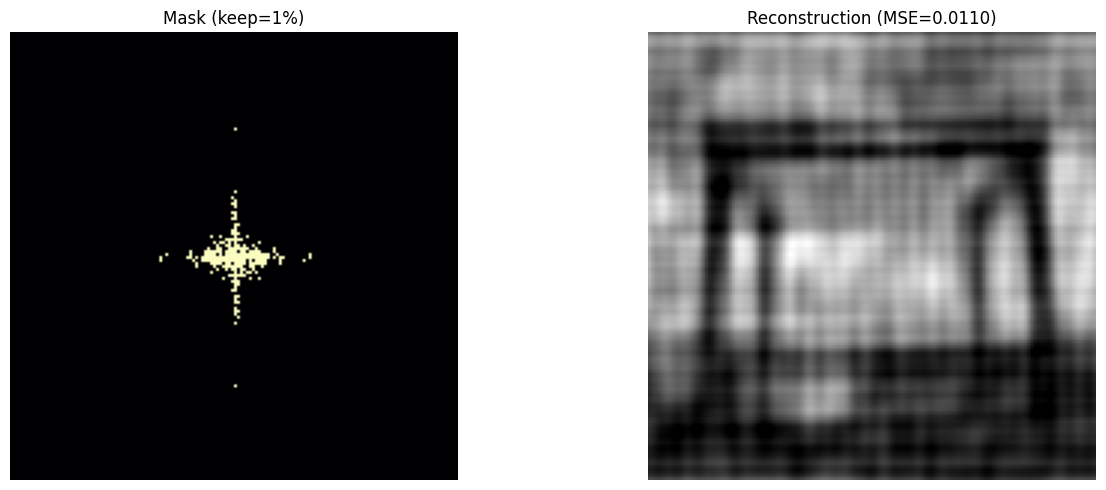

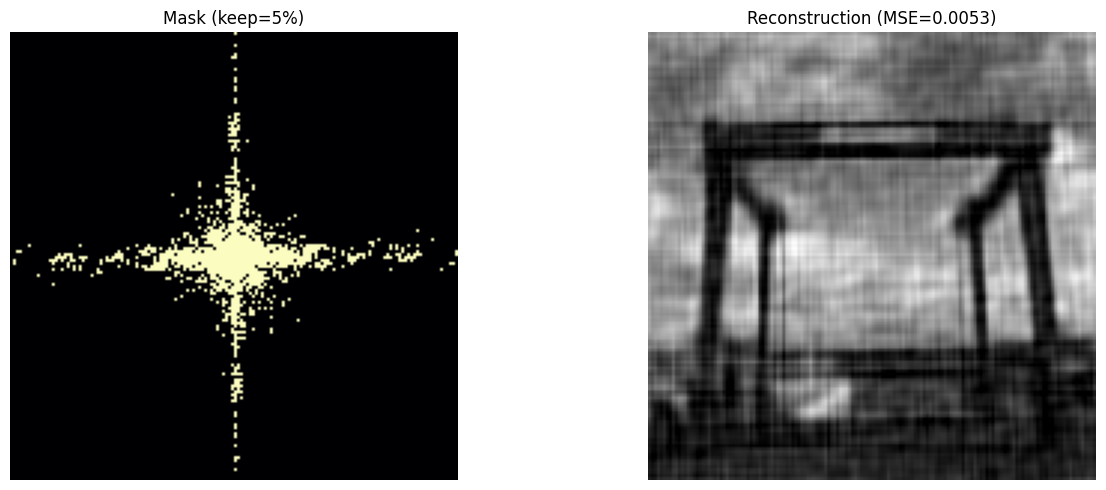

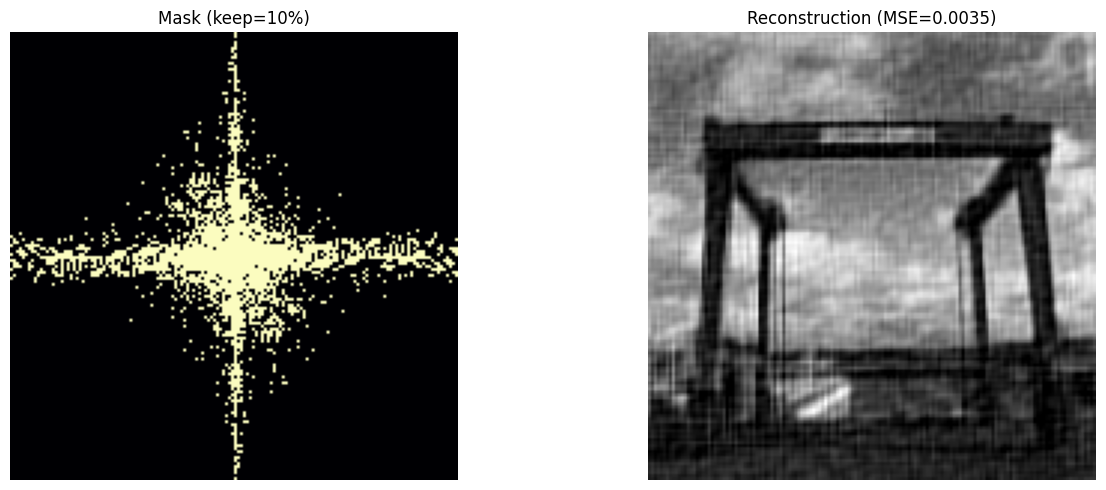

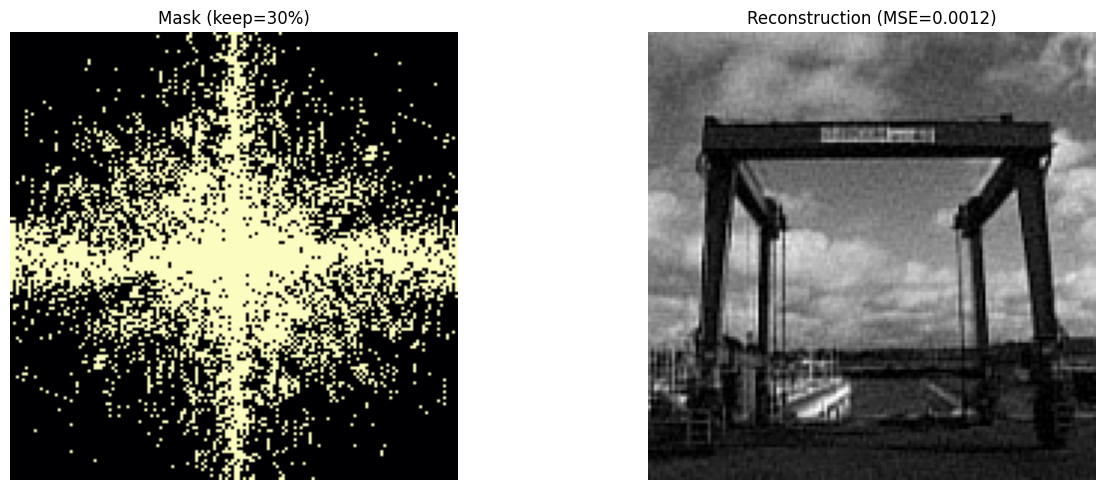

Compression summary (keep_ratio, MSE):
- 1% -> MSE=0.010998
- 5% -> MSE=0.005268
- 10% -> MSE=0.003484
- 30% -> MSE=0.001230


In [15]:
def compress_by_topk(F: np.ndarray, keep_ratio: float) -> np.ndarray:
    assert 0.0 < keep_ratio <= 1.0, "keep_ratio must be in (0,1]"
    flat = np.abs(F).ravel()
    k = max(1, int(np.ceil(len(flat) * keep_ratio)))
    thresh = np.partition(flat, -k)[-k]
    mask = (np.abs(F) >= thresh).astype(np.float32)
    return F * mask, mask


keep_list = [0.01, 0.05, 0.1, 0.3]
results = []

for keep_ratio in keep_list:
    F_topk, mask_topk = compress_by_topk(F, keep_ratio)
    img_rec = ifft2_img(F_topk)
    img_rec = np.clip(img_rec, 0.0, 1.0)
    mse = float(np.mean((img_rec - img) ** 2))
    results.append((keep_ratio, mse, img_rec, mask_topk))

for keep_ratio, mse, img_rec, mask_topk in results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].imshow(np.fft.fftshift(mask_topk), cmap='magma')
    axes[0].set_title(f"Mask (keep={keep_ratio*100:.0f}%)")
    axes[0].axis('off')

    axes[1].imshow(img_rec, cmap='gray')
    axes[1].set_title(f"Reconstruction (MSE={mse:.4f})")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

print("Compression summary (keep_ratio, MSE):")
for keep_ratio, mse, *_ in results:
    print(f"- {keep_ratio*100:.0f}% -> MSE={mse:.6f}")

We keep only a fraction p of the largest‑magnitude Fourier coefficients (top‑k) and set the rest to zero, then reconstruct while preserving phase. Natural images are energy‑compact in Fourier space: most power lies near the origin, so a relatively small set of large coefficients can be enough to grasp the essence of the picture and make it recognizable. As p increases, edges and textures return and the reconstruction error (like MSE) drops, very small p produces blur and mild ringing due to the hard threshold.

Phase is essential for keeping the shape and structure of the image, so even when much of the magnitude information is reduced, the result can still look realistic. The Top-k method is a simple way to limit how much data is kept. It’s not the most efficient compression method, but it clearly shows the balance between file size and image quality: the more coefficients we keep in the compression the more detailed the pictures are, as we can see in the images generated in the python cell above.